# Setup

## Import packages

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
import networkx as nx
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from tqdm import tqdm
from time import time, sleep

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

In [2]:
vx_sizes = [16, 16, 30]

def get_viewer(backgnd_color = "black"):
    viewer = neuroglancer.Viewer()
    viewer.set_state({})

    location=[17000,17000,1500]

    with viewer.config_state.txn() as s:
        s.show_layer_panel = True ###

    with viewer.txn(overwrite=True) as s:

        dimensions = neuroglancer.CoordinateSpace(
            scales=vx_sizes,# self.vx_sizes['em'],
            units='nm',
            names=['x', 'y', 'z']   )

        s.showSlices = False
        s.dimensions = dimensions
        s.position = array(location)
        s.layout = "3d"
        s.projectionScale = 30000
        s.projection_background_color= matplotlib.colors.cnames[backgnd_color]#"#000000"
        # s.projection_background_color= "#ffffff"
        s.showSlices = False

    with viewer.txn(overwrite=True) as s:
        wb_open(str(viewer))
    
    return viewer

def create_baseseg_layer(viewer, source, lname, visible = False, objectAlpha = 1):
    with viewer.txn(overwrite=True) as s:
        s.layers[lname] = neuroglancer.SegmentationLayer(source = source, segments=[], segment_colors={})
        s.layers[lname].ignoreNullVisibleSet = False
        s.layers[lname].pick = True
        s.layers[lname].selectedAlpha = 0.5 #For 2D
        s.layers[lname].objectAlpha = objectAlpha
        s.layers[lname].visible = visible
                 

def create_em_layer(viewer, source = 'brainmaps://10393113184:ell:roi450um_xyz'):
    with viewer.txn(overwrite=True) as s:
        s.layers['em'] = neuroglancer.ImageLayer(source = source)

def clear_baseseg_layer(viewer, lname):
    displayed_segs = set([str(x) for x in viewer.state.layers[lname].segments])

    # REMOVE SEGMENTS FROM NGviewer
    remove_segs = displayed_segs

    with viewer.txn(overwrite=True) as s:
        for bs in remove_segs:
            if int(bs) in s.layers[lname].segments:
                s.layers[lname].segments.remove(int(bs))

def point_on_line(u, v, d):
    delta_x = v[0] - u[0]
    delta_y = v[1] - u[1]
    length = (delta_x**2 + delta_y**2)**0.5  # Length of the line segment between u and v
    if length == 0:
        return u  # Return u if u and v coincide
    scaling_factor = d / length
    p = (u[0] + scaling_factor * delta_x, u[1] + scaling_factor * delta_y)
    return p

# Create custom arrow style as a function
def arrow_style(posA, posB, mutation_size, linewidth, linestyle, color):
    line1 = [(0, 0), (1, 0)]
    line2 = [(0, -0.2), (1, 0.2)]
    return patches.FancyArrowPatch(posA, posB, arrowstyle=patches.ArrowStyle.Simple(tail_width=linewidth, head_width=mutation_size, head_length=mutation_size * 2),
                                   color=color, linewidth=linewidth, linestyle=linestyle, mutation_scale=mutation_size,alpha = 0.5)


## Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [3]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

db_cursors = sqlite3_connect(settings_dict['db_path'], check_same_thread=False).cursor()

a = ', '.join(['base_address'])

db_cursors.execute(f'''SELECT {a} FROM addresses_table LIMIT 1''')

[base_seg] = db_cursors.fetchall()[0]


## Load files

In [4]:
dirpath = Path(settings_dict['save_dir'])


In [5]:
nodefiles = get_cell_filepaths(dirpath)

In [6]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn.csv')
syn = 'post-synaptic'

## Cell features to add

### Soma diameter

In [896]:
soma_diam = {}
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    if 'soma' in cell.cell_data['end_points'].keys():
        soma_anno = cell.cell_data['end_points']['soma']
        if len(soma_anno)==4:
            xpts = [p[0] for p in soma_anno]
            zpts = [p[2] for p in soma_anno]
            soma_diam[x] = np.mean([int((np.max(xpts)-np.min(xpts))),int((np.max(zpts)-np.min(zpts)))])/1000
        if len(soma_anno)!=4:
            soma_diam[x] = np.NaN
    
    if 'soma' not in cell.cell_data['end_points'].keys():
        soma_diam[x] = np.NaN


In [ ]:

for i,r in df_syn.iterrows():
    df_syn.loc[i,'pre_diam']=soma_diam[str(df_syn.loc[i,'pre'])]
    df_syn.loc[i,'post_diam']=soma_diam[str(df_syn.loc[i,'post'])]
df_syn.loc[:,'diam_diff'] = (df_syn['post_diam']-df_syn['pre_diam'])/df_syn['pre_diam']


In [900]:
soma_diam['216004541']

9.901

# Completeness of synapses

In [7]:
all_types = set(df_syn['pre_type'].unique()) | set(df_syn['post_type'].unique()) #- set(['glia'])
c_type_check = all_types #['mg1','mg2','sg1','sg2','grc']

df_progress = pd.DataFrame(columns = ['id','type','soma-diam','n_syn','done','todo','completed'])
for c in df_syn['pre'].unique():
    
    if (df_syn[df_syn['pre'] == c]['pre_type'].unique()[0] in c_type_check):

        c_df = df_syn[df_syn['pre'].isin([c])]

        cell = ecrest(settings_dict,filepath = nodefiles[str(c)],launch_viewer=False)

        cell_dict = {
            'id': cell.cell_data['metadata']['main_seg']['base'],
            'type': cell.get_ctype("manual"),
            # 'soma-diam': soma_diam[str(c)],
            'n_syn': len(cell.cell_data['end_points'][syn]),
            'done': len(c_df),
            'todo': len(cell.cell_data['end_points'][syn]) - len(c_df),
            'completed': len(c_df) / (len(cell.cell_data['end_points'][syn]))
            }

        df_progress = pd.concat([df_progress,pd.DataFrame([cell_dict])])

In [827]:
# df_progress

# Edges

## Filtered df_syn

In [8]:
# Filter by pre and/or post cell type

network_types = (set(df_syn['pre_type'].unique()) | set(df_syn['post_type'].unique())) - set(['glia','uk','fov']) #,'dml','tsd']) #'tsd','dml','sgx1','sgx2'])

In [9]:
df_syn = df_syn[(df_syn['pre_type'].isin(network_types))&(df_syn['post_type'].isin(network_types))] #- set(['lg','lf'])

if syn == 'pre-synaptic':
    df_syn.drop(df_syn[df_syn['pre'].isin([299392199,386392158,472361842,389085521,227254070,228321391,403522169,313068329,126649726])].index, inplace=True)


In [877]:
# Filter by completeness of synaptic reconstructions

if syn=='post':
    df_syn_completed = df_syn[df_syn['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.9]['id'].values])]
    df_syn = pd.concat(df_syn_completed,df_syn[df_syn['pre_type'].isin(['aff'])])
    
    
if syn=='pre':
    df_syn = df_syn[df_syn['pre'].isin([int(id_) for id_ in df_progress[df_progress['completed']>0.3]['id'].values])]
    # df_syn.rename(columns={'pre_type':'post_type','post_type':'pre_type'}, inplace=True)

## df_syn --> df_edges

In [10]:
# remove structure and soma diameter information if want to

df_syn = df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1)#,'pre_diam','post_diam','diam_diff'],axis=1)

In [11]:
df_edges=df_syn.value_counts().reset_index(name='weight')

## df_edges --> all_connections

mean connection quantifications

In [880]:
'''
# If wanted to do mean among only cells that made each type of connection...

# Group by 'pre_type', 'post_type', and 'pre', count unique 'post', then reset index
result_df = df_edges.groupby(['pre_type', 'post_type', 'pre'])['post'].nunique().reset_index()

# Group by 'pre_type' and 'post_type', calculate the mean of 'post' counts and rename the column
result_df.groupby(['pre_type', 'post_type'])['post'].mean().reset_index().rename(columns={'post': 'n_post'})'''


# calculates mean by dividing by total number of pre cells (labeled with syn and post reconstructed)

result_df = df_edges.groupby(['pre_type', 'post_type'])['weight'].sum().reset_index()

n_post = df_edges.groupby(['pre_type', 'post_type']).nunique().reset_index()[['pre_type','post_type','post']].rename(columns={'post':'n_post'})

result_df['n_post']=n_post['n_post']

n_cells = df_edges.groupby(['pre_type'])['pre'].nunique().reset_index()#res.groupby('pre_type')['weight'].sum()
n_cells = n_cells.rename(columns={'pre': 'n_pre'})
# np.round(result_df.weight / denom)
merged_df = pd.merge(result_df, n_cells, on='pre_type', how='left')

n_cells = df_edges.groupby(['post_type'])['post'].nunique().reset_index()#res.groupby('pre_type')['weight'].sum()
n_cells = n_cells.rename(columns={'post': 'n_post'})

# Calculate the mean weight from pre to post for each pre_type-post_type category
merged_df['mean_weight'] = (merged_df['weight'] / merged_df['n_pre'])#.apply(lambda x: '%.1f' % x)

merged_df['mean_cells'] =(merged_df['n_post'] / merged_df['n_pre'])#.apply(lambda x: '%.1f' % x)

# Drop unnecessary columns if needed
final_result = deepcopy(merged_df)#[['pre_type', 'post_type', 'mean_weight','mean_post']])

# Display the result
# final_result.head()

For postsynaptic reconstructions, just use result_df

In [881]:
final_result.loc[:,'direction']=syn

all_connections = final_result

For presynaptic reconstructions, need to switch pre and post columns of result df

In [585]:
final_result.loc[:,'direction']=syn
final_result.rename(columns={'pre_type':'post_type','post_type':'pre_type','n_post':'n_pre','n_pre':'n_post'}, inplace=True)

all_connections = final_result

In [500]:
## if merge pre and post results

# all_connections = pd.concat([all_connections,result_df])

# Create graph from all_connections

In [882]:
all_connections.head()#[all_connections['pre_type'].isin(['grc-d'])]

,pre_type,post_type,weight,n_post,n_pre,mean_weight,mean_cells,direction
0,aff,grc-d,154,67,1,154.0,67.0,post-synaptic
1,aff,grc-s,1,1,1,1.0,1.0,post-synaptic
2,aff,lf,18,6,1,18.0,6.0,post-synaptic
3,aff,mg2,9,6,1,9.0,6.0,post-synaptic
4,aff,sg2,15,9,1,15.0,9.0,post-synaptic


In [883]:

G = nx.DiGraph()  # Create a directed graph

# nodes_to_add = set(all_connections['pre_type'].unique())|set(all_connections['post_type'].unique())
G.add_nodes_from(set(all_connections['pre_type'].unique())|set(all_connections['post_type'].unique()))

for index, row in all_connections.iterrows():
    pre_type = row['pre_type']
    post_type = row['post_type']
    n_cells = row['mean_cells']
    u_weight = row['mean_weight']#.asfloat()
    direction = row['direction']

    if direction == 'pre-synaptic':
        edge_color = 'purple'
    if direction == 'post-synaptic':
        edge_color = 'green'

    G.add_edge(pre_type, post_type, weight=u_weight, color=edge_color)


If want all pathways in connectivity dataframe

In [884]:
subgraph = G

If want pathways from only certain origin types

In [889]:
selected_origin_types = ['grc-d','grc-s','sg1','sg2','aff','mg1','mg2'] #

# Filter edges based on the selected origin types
filtered_edges = [(u, v) for u, v in G.edges() if u in selected_origin_types]

# Create a subgraph using the filtered edges
subgraph = G.edge_subgraph(filtered_edges)

If want a pathway between specific cell types

In [886]:
# Source and target nodes
source = 'aff'
target = 'lf'

# Find all paths from source to target
all_paths = nx.all_simple_paths(subgraph, source=source, target=target, cutoff=3)


nodes_in_paths = set()
edges_in_paths = set()

for path in all_paths:
    nodes_in_paths.update(path)
    edges_in_paths.update(zip(path[:-1], path[1:]))

# Create a new graph and add nodes and edges from the paths
subgraph = nx.DiGraph()
subgraph.add_nodes_from(nodes_in_paths)
subgraph.add_edges_from(edges_in_paths)

for u, v in subgraph.edges():
    subgraph[u][v]['weight'] = G[u][v]['weight']

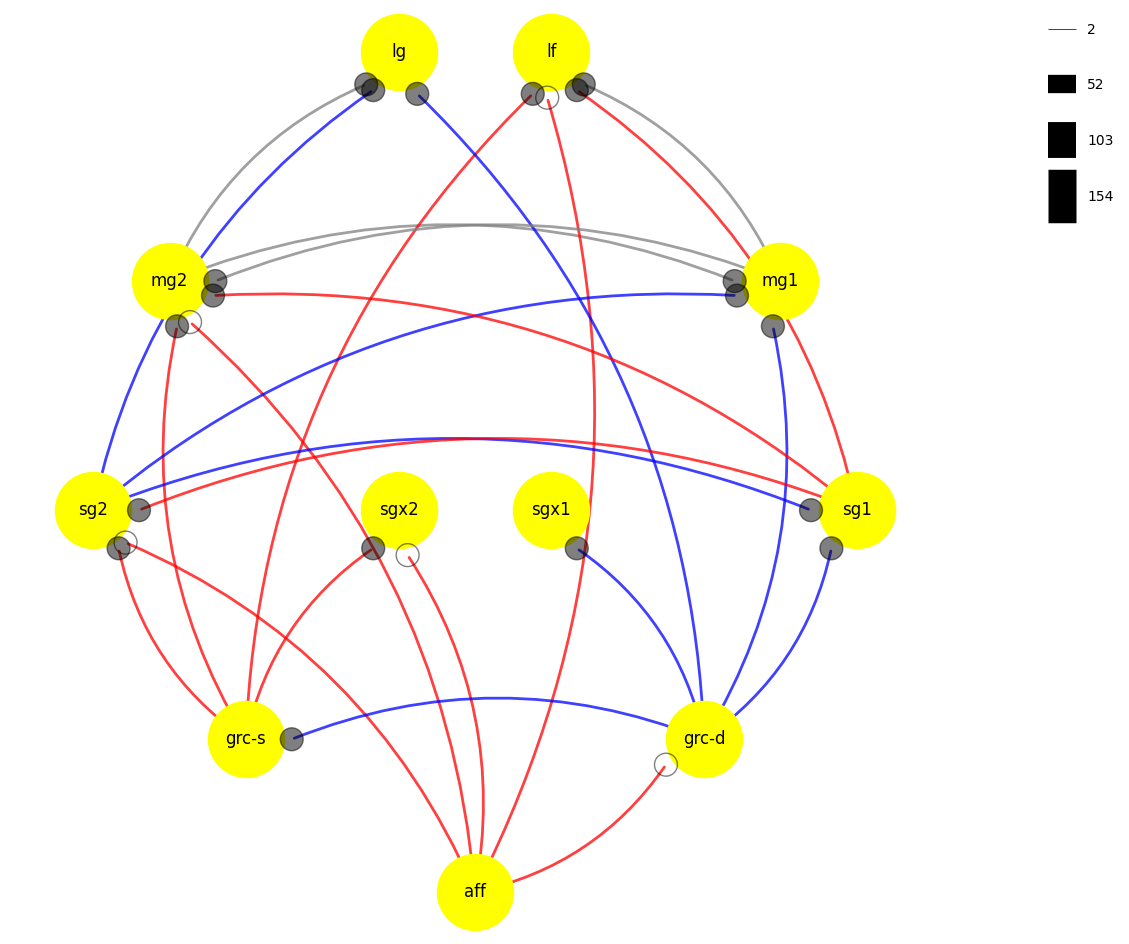

In [894]:
node_positions = {
    'aff': (3.5,1.5),
    'grc-s': (2,2.5),
    'grc-d': (5,2.5),
    'sgx2': (3,4),
    'sgx1': (4,4),
    'sg2': (1,4),
    'sg1': (6,4),
    'mg2': (1.5,5.5),
    'mg1': (5.5,5.5),
    'lg': (3,7),
    'lf': (4,7),
    'dml': (0.5,4.5),
    'tsd': (6.5,4.5),
    
}

# subgraph = G
color_spec = {'mg1':'gray',
             'sg1':'red',
             'grc-s':'red',
             'mg2':'gray',
             'sg2':'blue',
             'grc-d':'blue',
             'dml':'gray',
             'sgx1':'red',
             'sgx2':'blue',
             'aff':'red'}

# pos = nx.circular_layout(G) #kamada_kawai_layout(G) #spring_layout(G)  # Position nodes using a layout
hfig,ax = plt.subplots(1,figsize=(12,12))

min_weight = 2
weight_scale = 0.25

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos=node_positions,node_color='yellow', node_size=3000)
# Draw node labels
node_labels = {node: node for node in subgraph.nodes()}  # Assuming node labels are the same as node names
nx.draw_networkx_labels(subgraph, pos=node_positions, labels=node_labels, font_size=12)

d_stop_short = 0.3
for u, v, d in subgraph.edges(data=True):
    if d['weight']>min_weight:
        start = node_positions[u]
        stop = point_on_line(node_positions[v], node_positions[u], d_stop_short)
        
        rad_arc = 0.2
        if u in ['mg2','sg2','sgx-2','grc-s']: rad_arc = -0.2

        # Draw a curved line (without arrowhead) between nodes 'a' and 'b'
        arrow = patches.FancyArrowPatch(posA=start,
                                posB=stop,
                                arrowstyle='-',
                                color=color_spec[u],
                                linewidth= 2, #d['weight']*weight_scale,
                                mutation_scale=20,
                                connectionstyle=f"arc3,rad={rad_arc}",
                                alpha=0.75, zorder=0)
        plt.gca().add_patch(arrow)

        # Draw a circle at the terminal point (b node) of the edge
        circle_radius = 0.075  # Radius of the circle
        if u!='aff':
            circle_fill=True
        if u=='aff':
            circle_fill = False  # Set to True for a filled circle, False for an empty circle
        circle_edge_width = 1  # Line width of the circle edge

        circle = plt.Circle(point_on_line(node_positions[v], node_positions[u], d_stop_short), 
                            circle_radius, fill=circle_fill, alpha = 0.5, facecolor= 'black', edgecolor='black', linewidth=circle_edge_width, zorder=2)
        plt.gca().add_patch(circle)
    
# Set aspect ratio to be equal to ensure the circle appears as a circle
plt.axis('equal')

# Set axis limits and turn off axis for a cleaner visualization
# plt.xlim(-0.5, 2.5)
# plt.ylim(-0.5, 0.5)
plt.axis('off')


edge_weights = {(u, v): subgraph[u][v]['weight'] for u, v in subgraph.edges() if subgraph[u][v]['weight']>min_weight}

# Create a custom legend for edge widths
min_weight = min(edge_weights.values())
max_weight = max(edge_weights.values())
num_levels = 4  # Number of levels in the legend
lines = []
edges_weight_list=[]
for i in range(num_levels):
    level_weight = min_weight + (i / (num_levels - 1)) * (max_weight - min_weight)
    lines.append(Line2D([],[], linewidth=level_weight*weight_scale, color='black',solid_capstyle='butt'))
    edges_weight_list.append(int(level_weight))

legend = plt.legend(lines, edges_weight_list, bbox_to_anchor=(1.2,1), frameon=False,labelspacing=3)#,prop={'solid_capstyle':'butt'}) 


# Show the plot
plt.show()


In [598]:
edge_weights

{('mg1', 'mg2'): 25.5,
 ('aff', 'mg2'): 6.5,
 ('aff', 'grc-d'): 21.4,
 ('aff', 'sg2'): 18.0,
 ('sg2', 'mg1'): 39.333333333333336,
 ('grc-s', 'mg2'): 41.0,
 ('sg1', 'mg2'): 119.0,
 ('sg1', 'grc-s'): 1.875,
 ('grc-d', 'mg1'): 33.666666666666664,
 ('grc-d', 'grc-s'): 25.125,
 ('grc-d', 'sg1'): 40.75}

# Graph with individual cells to search paths

Uses df_edges

In [12]:
def find_paths_with_limit(graph, max_steps, source = None, source_type=None, target=None, target_type=None):
    paths = []
                    
    if source_type!=None:
        for node in graph.nodes():
            if graph.nodes[node]['cell_type'] == source_type:
                
                if target_type!=None:
                    for target_node in find_nodes_by_cell_type(graph, target_type):
                        for path in nx.all_simple_paths(graph, source=node, target=target_node, cutoff=max_steps):
                            path_with_types = [(n, graph.nodes[n]['cell_type']) for n in path]
                            paths.append(path_with_types)
                            
                if target_type==None:
                    for path in nx.all_simple_paths(graph, source=node, target=target, cutoff=max_steps):
                        path_with_types = [(n, graph.nodes[n]['cell_type']) for n in path]
                        paths.append(path_with_types)
                        
    if source_type==None:
        
        if target_type!=None:
            for target_node in find_nodes_by_cell_type(graph, target_type):
                for path in nx.all_simple_paths(graph, source=source, target=target_node, cutoff=max_steps):
                    path_with_types = [(n, graph.nodes[n]['cell_type']) for n in path]
                    paths.append(path_with_types)

        if target_type==None:
            for path in nx.all_simple_paths(graph, source=source, target=target, cutoff=max_steps):
                path_with_types = [(n, graph.nodes[n]['cell_type']) for n in path]
                paths.append(path_with_types)
                   
    return paths

# Function to find nodes by cell type
def find_nodes_by_cell_type(graph, cell_type):
    nodes_with_cell_type = []
    for node in graph.nodes():
        if graph.nodes[node]['cell_type'] == cell_type:
            nodes_with_cell_type.append(node)
    return nodes_with_cell_type

In [13]:
df_edges.head()

,pre,post,pre_type,post_type,weight
0,306461085,301863996,sg2,lg,32
1,130781211,215526370,sg2,lg,32
2,473631846,305332461,mg2,lg,30
3,41579854,393078033,mg1,lf,29
4,300131090,392814322,mg1,lf,29


In [14]:
cell_types = {}

for i,r in df_edges.iterrows():
    cell_types[r['pre']]=r['pre_type']
    cell_types[r['post']]=r['post_type']
    


In [15]:
nodes_to_graph = set(df_edges['pre'].unique())|set(df_edges['post'].unique())

In [16]:

G = nx.DiGraph()

# Add nodes with unique IDs and cell_type attribute
for k in nodes_to_graph:
    G.add_node(k, cell_type=cell_types[k])
# Add more nodes as needed

# Add edges between nodes (neurons
for index, row in df_edges.iterrows():
    pre_type = row['pre']
    post_type = row['post']
    weight = row['weight']

    if syn == 'pre-synaptic':
        G.add_edge(post_type, pre_type, weight=weight)
    if syn == 'post-synaptic':
        G.add_edge(pre_type, post_type, weight=weight)

In [862]:
# example cells that are interconnected

aff_cells=[61319896,568432342,483689146,309693374,559289471,558160524,561563174,484864533]

In [29]:
paths = find_paths_with_limit(G, max_steps=2, source=285761792, target_type='lg')
for p in paths:
    try:
        if p[2][0] in [215526370,483687142,393325331,48573302,393078033]: #=='lg') | (p[2][1]==215526370):
            print(p)
            
    except:
        if len(p)<3:
            print(p)
            continue
# [p for p in paths if (len(p)>2) & ((p[2][0]==285761792) | (p[2][0]==215526370))]
# paths

[(285761792, 'none'), (44933647, 'lg')]
[(285761792, 'none'), (221326165, 'sg2'), (215526370, 'lg')]
[(285761792, 'none'), (300316308, 'mg2'), (215526370, 'lg')]
[(285761792, 'none'), (128536704, 'mg2'), (215526370, 'lg')]
[(285761792, 'none'), (215526370, 'lg')]


In [37]:
grcs_cells = list(set([l[0][0] for l in paths]))

In [42]:
len(grcs_cells)

13

In [19]:
c_id = [l[1][0] for l in paths]
c_t = [l[1][1] for l in paths]

In [28]:
pd.DataFrame({'id':c_id,'type':c_t}).drop_duplicates(ignore_index=True).groupby(['type']).count()

,id
type,
grc-d,3
mg2,2
sg2,2
sgx2,1


In [46]:
find_paths_with_limit(G, max_steps=1, source_type='aff', target_type = 'grc-d')

[[(55472256, 'aff'), (226019332, 'grc-d')],
 [(55472256, 'aff'), (228366816, 'grc-d')],
 [(56553977, 'aff'), (226019332, 'grc-d')],
 [(60129918, 'aff'), (223881844, 'grc-d')],
 [(60129918, 'aff'), (482680782, 'grc-d')],
 [(60159066, 'aff'), (482680782, 'grc-d')],
 [(223835257, 'aff'), (481412554, 'grc-d')],
 [(223835257, 'aff'), (227254070, 'grc-d')],
 [(223835257, 'aff'), (482680782, 'grc-d')],
 [(400258384, 'aff'), (482680782, 'grc-d')],
 [(60192229, 'aff'), (223881844, 'grc-d')],
 [(60192229, 'aff'), (482680782, 'grc-d')],
 [(60081840, 'aff'), (223881844, 'grc-d')],
 [(60081840, 'aff'), (482680782, 'grc-d')],
 [(54372224, 'aff'), (226019332, 'grc-d')],
 [(54372224, 'aff'), (228366816, 'grc-d')],
 [(666982330, 'aff'), (481412554, 'grc-d')],
 [(60143700, 'aff'), (483689146, 'grc-d')],
 [(60143700, 'aff'), (481412554, 'grc-d')],
 [(57714981, 'aff'), (226019332, 'grc-d')],
 [(57714981, 'aff'), (228366816, 'grc-d')],
 [(56662421, 'aff'), (226019332, 'grc-d')],
 [(56662421, 'aff'), (22836

In [47]:
grc_cells = [483689146,481412554]

In [ ]:
source_type = 'aff'
target_type = 'lg'
max_steps = 3  # Maximum number of steps in the path

paths = find_paths_with_limit(G, max_steps, source_type=source_type, target_type=target_type)

paths

In [824]:
sg2_cells = [l_[0][0] for l_ in paths]

In [ ]:
source_type = 'grc-d'
target_type = 'lg'
max_steps = 1  # Maximum number of steps in the path

paths = find_paths_with_limit(G, max_steps, source_type, target_type)
paths


In [817]:
grcd_cells = [l_[0][0] for l_ in paths]

## visualize cell structure by type

requires cell structure labeling to be done 

In [38]:
syn_colors = {
    'sgx1':'#adebeb', #'#996633',
    'sgx2':'#cc9900',
    'sg1':'#00ffff',
    'sg2':'#ff9900',
    'grc-d':'#33cc33',
    'grc-s':'#e6e600',
    'dml':'#cccccc',
    'mg1':'#0000ff',
    'mg2':'#ff0000',
    'lg':'#8000c8',
    'lf':'#c80080',
    'aff':'#ffffff',#'#ffc0cb',
    'tsd':'#737373' 
}

In [50]:
viewer = get_viewer(backgnd_color="white")
create_em_layer(viewer)

add pre cell basal dendrites

In [40]:
segs_to_add = {}
structure_label = 'basal dendrite'
for c_id in grc_cells: #random.sample(cells_to_add,k=10):
    cell = ecrest(settings_dict,filepath = dirpath / nodefiles[str(c_id)], launch_viewer=False)
    if cell.cell_data['base_segments'][structure_label] != set():
        segs_to_add[c_id] = cell.cell_data['base_segments'][structure_label] #[a for b in cell.cell_data['base_segments'].values() for a in b]

# each cell to same tab
lname = str(c_id) + '_' + 'grcs'
create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)

# each cell to a different tab    
for c_id,b_ in segs_to_add.items():
    # lname = str(c_id) + '_' + cell_types[c_id]
    # create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)
    with viewer.txn(overwrite=True) as s:
        for bs in b_: 
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = syn_colors[cell_types[c_id]]#'#996633' #structure_colors[dtype] # blue
    sleep(2)

add afferents

In [48]:
aff_cells = [61319896]
aff_cells = grc_cells

In [49]:
segs_to_add = {}
for c_id in aff_cells: #random.sample(cells_to_add,k=10):
    cell = ecrest(settings_dict,filepath = dirpath / nodefiles[str(c_id)], launch_viewer=False)
    if cell.cell_data['base_segments'] != set():
        segs_to_add[c_id] = cell.cell_data['base_segments'] #[a for b in cell.cell_data['base_segments'].values() for a in b]

## add each cell to the same tab
# lname = str(c_id) + '_' + 'aff'
# create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)
    
# each cell to a different tab    
for c_id,b_ in segs_to_add.items():
    lname = str(c_id) + '_' + cell_types[c_id]
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 1)
    with viewer.txn(overwrite=True) as s:
        for k,v in b_.items(): 
            for bs in v:
                s.layers[lname].segments.add(int(bs))
                s.layers[lname].segment_colors[int(bs)] = syn_colors[cell_types[c_id]]#'#996633' #structure_colors[dtype] # blue
    sleep(2)

add target cell basal dendrites

In [54]:
target_cell = 301787806
segs_to_add = {}
structure_label = 'basal dendrite'
for c_id in [target_cell]: #random.sample(cells_to_add,k=10):
    cell = ecrest(settings_dict,filepath = dirpath / nodefiles[str(c_id)], launch_viewer=False)
    if cell.cell_data['base_segments'][structure_label] != set():
        segs_to_add[c_id] = cell.cell_data['base_segments'][structure_label] #[a for b in cell.cell_data['base_segments'].values() for a in b]
    

# each cell to a different tab    
for c_id,b_ in segs_to_add.items():
    lname = str(c_id) #+ '_' + cell.get_ctype('manual')
    create_baseseg_layer(viewer, base_seg, lname, objectAlpha = 0.5)
    with viewer.txn(overwrite=True) as s:
        for bs in b_: 
            s.layers[lname].segments.add(int(bs))
            s.layers[lname].segment_colors[int(bs)] = 'black'#syn_colors[cell_types[c_id]]#'#996633' #structure_colors[dtype] # blue
    sleep(2)